In [49]:
import sys
import pickle
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

In [50]:
!ls /export/data/dataset/CIFAR

cifar-10-batches-py	cifar-100-python
cifar-10-python.tar.gz	cifar-100-python.tar.gz


In [51]:
def unpickle(file):
    fp = open(file, 'rb')
    if sys.version_info.major == 2:
        data = pickle.load(fp)
    elif sys.version_info.major == 3:
        data = pickle.load(fp, encoding='latin-1')
    fp.close()
    return data

In [52]:
def get_cifar10(folder):
    tr_data = np.empty((0,32*32*3))
    tr_labels = np.empty(1)
    '''
    32x32x3
    '''
    for i in range(1,6):
        fname = os.path.join(folder, "%s%d" % ("data_batch_", i))
        data_dict = unpickle(fname)
        if i == 1:
            tr_data = data_dict['data']
            tr_labels = data_dict['labels']
        else:
            tr_data = np.vstack((tr_data, data_dict['data']))
            tr_labels = np.hstack((tr_labels, data_dict['labels']))

    data_dict = unpickle(os.path.join(folder, 'test_batch'))
    te_data = data_dict['data']
    te_labels = np.array(data_dict['labels'])

    bm = unpickle(os.path.join(folder, 'batches.meta'))
    label_names = bm['label_names']
    return tr_data, tr_labels, te_data, te_labels, label_names

In [458]:
datapath = "/export/data/dataset/CIFAR/cifar-10-batches-py"

tr_data10, tr_labels10, te_data10, te_labels10, label_names10 = get_cifar10(datapath)

In [459]:
tr_data10_=np.reshape(tr_data10,(-1,3,32,32))#.transpose((0,3,2,1))
te_data10_=np.reshape(te_data10,(-1,3,32,32))#.transpose((0,3,2,1))
te_img=np.reshape(te_data10,(-1,3,32,32)).transpose((0,3,2,1))

In [460]:
len(tr_data10_)

50000

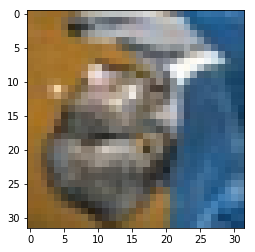

In [461]:
plt.imshow(te_img[0])

In [462]:
img=te_img[0]#te_data10_[0]

In [463]:
def addGaussianNoise(src,sigma):
    row,col,ch= src.shape
    mean = 0
    sigma = sigma
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss
    noisy=np.clip(noisy, 0, 255)
    noisy=noisy.astype("int16")
    noisy=np.array(noisy, dtype=np.uint8)
    return noisy

In [464]:
sigma=10
after_image=addGaussianNoise(img,sigma)

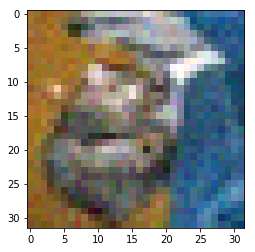

In [465]:
plt.imshow(after_image)

In [466]:
tr_data10_noise=tr_data10_
for i in range(tr_data10_.shape[0]):
    tr_data10_noise[i]=addGaussianNoise(tr_data10_[i],sigma)

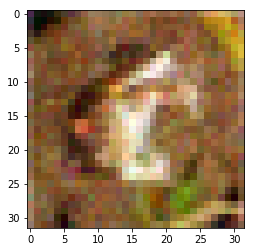

In [467]:
plt.imshow(tr_data10_noise[0].transpose((2,1,0)))

In [468]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.cluster import KMeans

In [469]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,datas,labels,data_num, transform=None):
        self.transform = transform
        self.data_num = data_num
        self.data = []
        self.label = []
        for x in range(self.data_num):
            self.data.append(datas[x])
            self.label.append(labels[x])

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [475]:
data_set = MyDataset(tr_data10_noise,tr_data10_,50000, transform=None)

In [476]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,padding=1)
        self.conv2 = nn.Conv2d(6,16,3,padding=1)
        #self.conv3 = nn.Conv2d(16,32,5,1)
        
        #self.deconv1 = nn.ConvTranspose2d(32,16,5,2)
        self.deconv2 = nn.ConvTranspose2d(16,6,4,stride=2,padding=1)
        self.deconv3 = nn.ConvTranspose2d(6,3,4,stride=2,padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x) 
        #print(x.size())
        #x = self.relu(self.conv3(x))
        #x = self.pool(x) 
        #x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        #print(x.size())
        x = self.sigmoid(self.deconv3(x))
        #print(x.size())
        return x*255
    
    def encoder(self,x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decoder(self,x):
        x = self.relu(self.deconv2(x))
        x = self.sigmoid(self.deconv3(x))
        return x
net = Net()

In [477]:
train_loader = DataLoader(data_set,batch_size=100,shuffle = True)

In [478]:
def train_net(n_epochs, train_loader, net, optimizer_cls = optim.Adam,
              loss_fn = nn.MSELoss(), device = "cuda:0"):
    """
    n_epochs…訓練の実施回数
    net …ネットワーク
    device …　"cpu" or "cuda:0"
    """
    losses = []         #loss_functionの遷移を記録
    optimizer = optimizer_cls(net.parameters(), lr = 0.001)
    net.to(device)
    
    for epoch in range(n_epochs):
        running_loss = 0.0  
        net.train()

        for i, XY in enumerate(train_loader):
            X,Y=XY[0],XY[1]
            X= X.float().to(device)
            Y= Y.float().to(device)
            optimizer.zero_grad()
            X_pred = net(X)
            loss = loss_fn(Y, X_pred)   #予測データと元のデータの予測
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        losses.append(running_loss / i)
        print("epoch", epoch, ": ", running_loss / i)

    return losses

losses = train_net(n_epochs = 200,
                   train_loader = train_loader,
                   net = net)

epoch 0 :  2416.3190082557694
epoch 1 :  897.0327950823522
epoch 2 :  769.2308129442479
epoch 3 :  697.747586359242
epoch 4 :  651.9467736743018
epoch 5 :  617.3143599210139
epoch 6 :  591.2697338035446
epoch 7 :  568.2610343367398
epoch 8 :  550.018433595707
epoch 9 :  534.1855910918516
epoch 10 :  522.4269202467435
epoch 11 :  508.3125047091253
epoch 12 :  495.6073361322254
epoch 13 :  482.44008072296936
epoch 14 :  463.12024763638607
epoch 15 :  449.675263246219
epoch 16 :  440.32585373383483
epoch 17 :  433.15411994643586
epoch 18 :  427.4267091311529
epoch 19 :  422.0736334118432
epoch 20 :  418.10460117011365
epoch 21 :  412.44604773511867
epoch 22 :  409.07128942944485
epoch 23 :  404.99510159234484
epoch 24 :  403.23641704796313
epoch 25 :  398.93052639703234
epoch 26 :  396.77510135016126
epoch 27 :  394.3243760470159
epoch 28 :  392.1582324194287
epoch 29 :  390.5855123944177
epoch 30 :  388.46888197782283
epoch 31 :  386.4988551932968
epoch 32 :  384.4995282312672
epoch 33 :

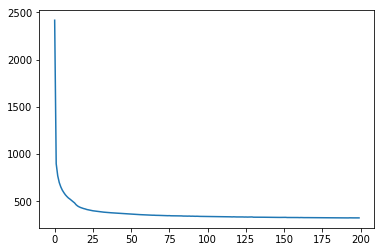

In [479]:
plt.plot(losses)

In [480]:
te=torch.tensor(te_data10_[0:100], dtype = torch.float32).to("cuda:0")

In [481]:
re_img=net(te)

In [482]:
re_img=re_img.to('cpu')
re_img=re_img.int()

In [483]:
re_img=re_img.detach().numpy()

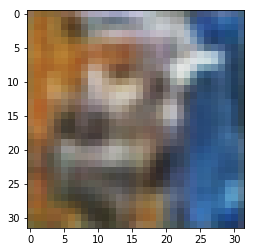

In [484]:
img=re_img.transpose((0,3,2,1))
plt.imshow(img[0])

In [485]:
feature=net.encoder(te)

In [486]:
feature=feature.to('cpu')
feature=feature.detach().numpy()

In [487]:
feature.shape

(100, 16, 8, 8)

In [488]:
cu=KMeans(n_clusters=5).fit_predict(feature.reshape(100,-1))

In [489]:
cluster=[[] for i in range(5) ]
for i in range(feature.shape[0]):
    cluster[cu[i]].append(te_img[i])

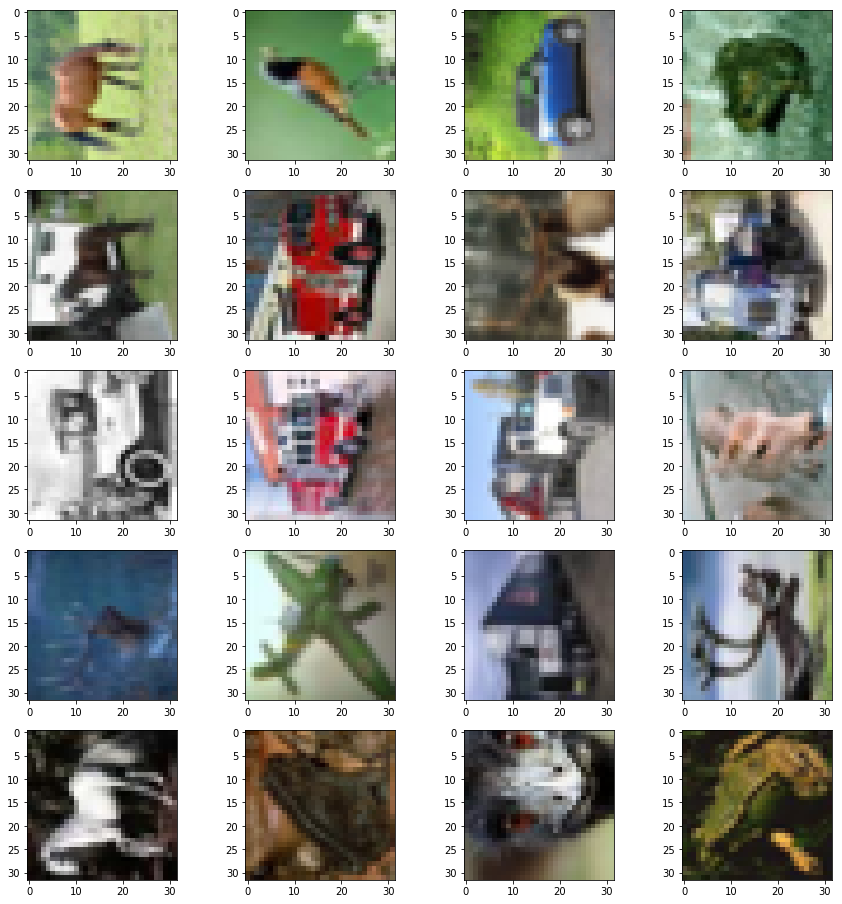

In [498]:
num=20#te_img.shape[0]
line=4
f, axarr = plt.subplots(int(num/line),line, figsize=(15,15*int(num/line/line)+1))
for i in range(num):
    ax = axarr[int(i/line)][i%line]
    ax.imshow(cluster[int(i/line)][i%line+5])

In [491]:
distance=[]
for i in range(0,feature.shape[0]):
    dis=np.linalg.norm(feature[0]-feature[i])
    distance.append([dis,i])

In [492]:
distance.sort(key=lambda x: x[0])

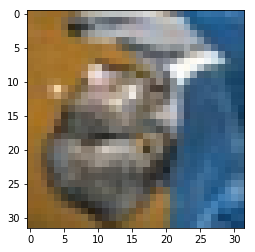

In [493]:
plt.imshow(te_img[distance[0][1]])

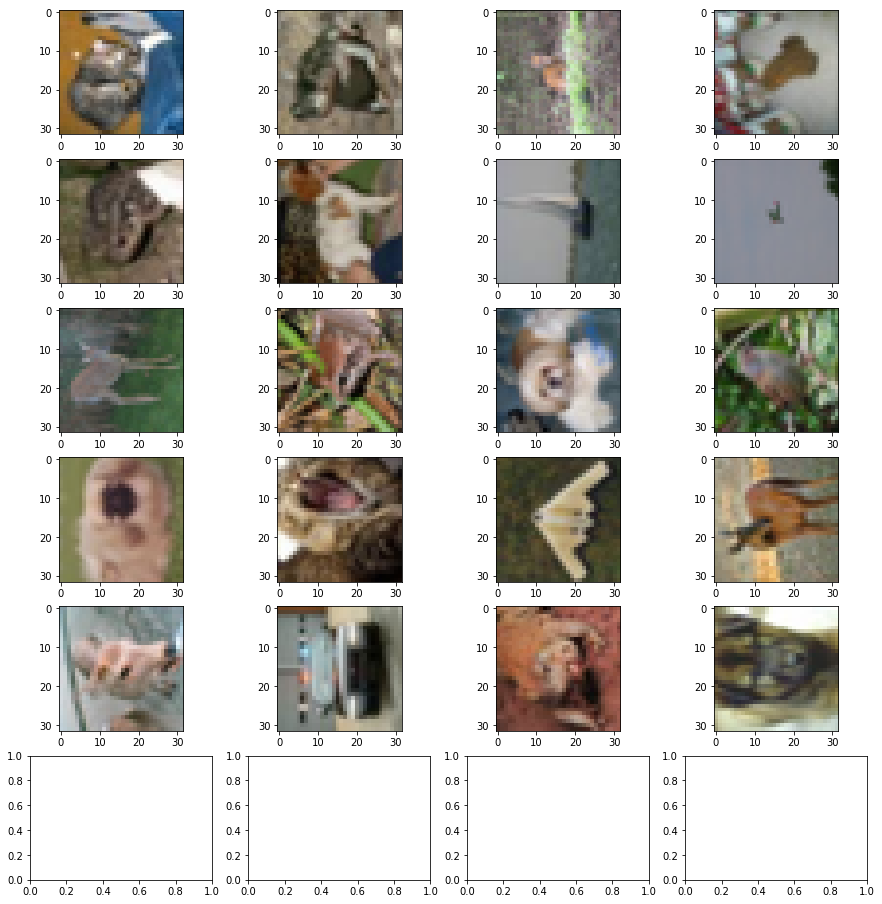

In [494]:
num=20#te_img.shape[0]
line=4
f, axarr = plt.subplots(int(num/line)+1,line, figsize=(15,15*int(num/line/line)+1))
for i in range(num):
    ax = axarr[int(i/line)][i%line]
    ax.imshow(te_img[distance[i][1]])

In [499]:
import cloudpickle

In [501]:
with open('AutoEncoder.pkl', 'wb') as f:
    cloudpickle.dump(net, f)

In [ ]:
#with open('AutoEncode.pkl', 'rb') as f:
#    model = cloudpickle.load(f)